# Spotify & Air Quality Data Engineering Project

## Motivation and Goal
The goal of this project is to build a data engineering pipeline using real world data from the Spotify API and a public Air Quality dataset. I will:

1. Extract data from an API and CSV source.
2. Clean and transform the data into normalized tables.
3. Load data into a SQL database.
4. Run queries and generate plots to explore trends and insights.

## Data Sources
1. Spotify API: Track, artist, and playlist data
   - Link to API: https://developer.spotify.com/documentation/web-api/
2. Air Quality CSV: New York City air quality surveillance data
   - Link to CSV: https://catalog.data.gov/dataset/air-quality/resource/f3ed1638-92da-4f88-bb6b-7d3940514574#



In [3]:
#spotify api extraction
!pip install spotipy

# libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

#spotify API details
client_id = '6b28b8ff99d84bfd8f632809fb58b007'
client_secret = '8bcc9285397b42728aea0d5303f2f134'

# authenticate
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))


playlist_id = '3cEYpjA9oz9GiPac4AsH4n'
results = sp.playlist_items(playlist_id, limit=100, offset=0)

tracks_list = []
for i in range(0, 1000, 100):
    results = sp.playlist_items(playlist_id, limit=100, offset=i)
    for item in results['items']:
        track = item['track']
        tracks_list.append({
            'track_id': track['id'],
            'track_name': track['name'],
            'artist_name': track['artists'][0]['name'],
            'album_name': track['album']['name'],
            'popularity': track['popularity'],
            'duration_ms': track['duration_ms']
        })

# convert to DataFrame
spotify_df = pd.DataFrame(tracks_list)
spotify_df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.2/354.2 kB 7.5 MB/s eta 0:00:00


,track_id,track_name,artist_name,album_name,popularity,duration_ms
0,4rzfv0JLZfVhOhbSQ8o5jZ,Api,Odiseo,Progressive Psy Trance Picks Vol.8,5,376000
1,5o3jMYOSbaVz3tkgwhELSV,Is,Vlasta Marek,Wellness & Dreaming Source,0,730066
2,4Cy0NHJ8Gh0xMdwyM9RkQm,All I Want,LCD Soundsystem,This Is Happening,50,401440
3,6hvFrZNocdt2FcKGCSY5NI,Endpoints,Glenn Horiuchi,Glenn Horiuchi Trio / Gelenn Horiuchi Quartet:...,0,358760
4,2E2znCPaS8anQe21GLxcvJ,You Are So Beautiful,Zucchero,All The Best (Spanish Version),0,176093


In [4]:
#get air quality csv

from google.colab import files
uploaded = files.upload()


air_df = pd.read_csv('Air_Quality.csv')
air_df.head()

# check info
air_df.info()


Saving Air_Quality.csv to Air_Quality.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18862 entries, 0 to 18861
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unique ID       18862 non-null  int64  
 1   Indicator ID    18862 non-null  int64  
 2   Name            18862 non-null  object 
 3   Measure         18862 non-null  object 
 4   Measure Info    18862 non-null  object 
 5   Geo Type Name   18862 non-null  object 
 6   Geo Join ID     18862 non-null  int64  
 7   Geo Place Name  18862 non-null  object 
 8   Time Period     18862 non-null  object 
 9   Start_Date      18862 non-null  object 
 10  Data Value      18862 non-null  float64
 11  Message         0 non-null      float64
dtypes: float64(2), int64(3), object(7)
memory usage: 1.7+ MB


In [5]:
# api data cleaning
# check for missing values
spotify_df.isnull().sum()

# remove duplicates
spotify_df.drop_duplicates(subset='track_id', inplace=True)

# fill missing popularity with 0
spotify_df['popularity'].fillna(0, inplace=True)


/tmp/ipython-input-3400915285.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spotify_df['popularity'].fillna(0, inplace=True)


In [6]:
# csv cleaning
# check for missing values
air_df.isnull().sum()

# convert datetime column
air_df['datetime'] = pd.to_datetime(air_df['Start_Date'], format='%m/%d/%Y')


# fill or remove missing pollutant values
air_df['Data Value'].fillna(air_df['Data Value'].mean(), inplace=True)
air_df.rename(columns={'Data Value': 'value'}, inplace=True)




/tmp/ipython-input-1000729773.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  air_df['Data Value'].fillna(air_df['Data Value'].mean(), inplace=True)


In [7]:
#transformation
# api table
spotify_tracks = spotify_df[['track_id', 'track_name', 'artist_name', 'album_name', 'popularity', 'duration_ms']]

#csv table
# convert Start_Date to datetime
air_df['datetime'] = pd.to_datetime(air_df['Start_Date'], format='%m/%d/%Y')

# rename Data Value to 'value'
air_df.rename(columns={'Data Value': 'value'}, inplace=True)

# map station info
stations = air_df[['Geo Join ID', 'Geo Place Name']].drop_duplicates()
stations.rename(columns={'Geo Join ID': 'station_id', 'Geo Place Name': 'city'}, inplace=True)

# add pollutant column
air_df['pollutant'] = 'PM2.5'

# create normalized observations table
air_observations = air_df[['Geo Join ID', 'datetime', 'pollutant', 'value']]
air_observations.rename(columns={'Geo Join ID': 'station_id'}, inplace=True)




/tmp/ipython-input-1712208362.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_observations.rename(columns={'Geo Join ID': 'station_id'}, inplace=True)


In [8]:
# load into SQL
import sqlite3

# connect to SQLite database
conn = sqlite3.connect('spotify_air_quality.db')

# load tables
spotify_tracks.to_sql('spotify_tracks', conn, if_exists='replace', index=False)
stations.to_sql('stations', conn, if_exists='replace', index=False)
air_observations.to_sql('air_quality_observations', conn, if_exists='replace', index=False)

# verify tables
pd.read_sql('SELECT * FROM spotify_tracks LIMIT 5', conn)


,track_id,track_name,artist_name,album_name,popularity,duration_ms
0,4rzfv0JLZfVhOhbSQ8o5jZ,Api,Odiseo,Progressive Psy Trance Picks Vol.8,5,376000
1,5o3jMYOSbaVz3tkgwhELSV,Is,Vlasta Marek,Wellness & Dreaming Source,0,730066
2,4Cy0NHJ8Gh0xMdwyM9RkQm,All I Want,LCD Soundsystem,This Is Happening,50,401440
3,6hvFrZNocdt2FcKGCSY5NI,Endpoints,Glenn Horiuchi,Glenn Horiuchi Trio / Gelenn Horiuchi Quartet:...,0,358760
4,2E2znCPaS8anQe21GLxcvJ,You Are So Beautiful,Zucchero,All The Best (Spanish Version),0,176093


In [9]:
# queries + analysis
# example Query 1: Top 10 popular tracks
query = 'SELECT track_name, artist_name, popularity FROM spotify_tracks ORDER BY popularity DESC LIMIT 10'
pd.read_sql(query, conn)

# Example Query 2: Average pollutant values per city
query2 = '''
SELECT s.city, a.pollutant, AVG(a.value) as avg_value
FROM air_quality_observations a
JOIN stations s ON a.station_id = s.station_id
GROUP BY s.city, a.pollutant
'''
pd.read_sql(query2, conn)

# 3. Average track popularity per artist
query3 = '''
SELECT artist_name, AVG(popularity) as avg_popularity
FROM spotify_tracks
GROUP BY artist_name
ORDER BY avg_popularity DESC
LIMIT 10
'''
pd.read_sql(query3, conn)

# 4. Top 5 cities with highest PM2.5 average
query4 = '''
SELECT s.city, AVG(a.value) as avg_pm25
FROM air_quality_observations a
JOIN stations s ON a.station_id = s.station_id
WHERE a.pollutant = 'pm25'
GROUP BY s.city
ORDER BY avg_pm25 DESC
LIMIT 5
'''
pd.read_sql(query4, conn)

# 5. Most common pollutant per city
query5 = '''
SELECT city, pollutant, COUNT(*) as count
FROM air_quality_observations a
JOIN stations s ON a.station_id = s.station_id
GROUP BY city, pollutant
ORDER BY city, count DESC
'''
pd.read_sql(query5, conn)



,city,pollutant,count
0,Bay Ridge and Dyker Heights (CD10),PM2.5,292
1,Bayside - Little Neck,PM2.5,292
2,Bayside Little Neck-Fresh Meadows,PM2.5,105
3,Bayside and Little Neck (CD11),PM2.5,116
4,Bedford Stuyvesant (CD3),PM2.5,397
...,...,...,...
109,West Queens,PM2.5,397
110,Williamsbridge and Baychester (CD12),PM2.5,116
111,Williamsburg - Bushwick,PM2.5,397
112,Willowbrook,PM2.5,292


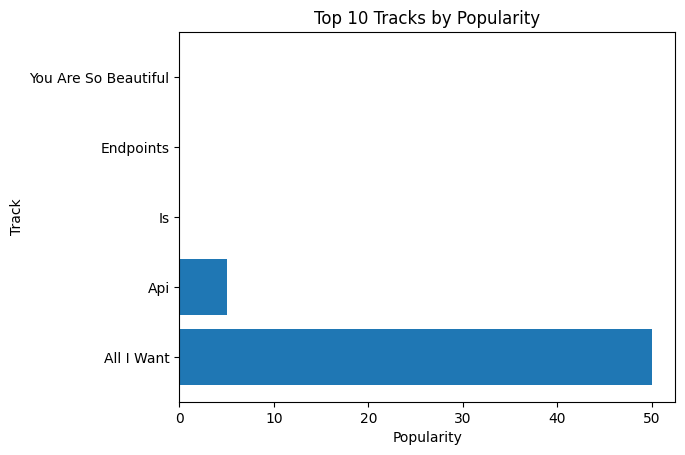

In [ ]:
# plots
import matplotlib.pyplot as plt

# Example: Top 10 tracks by popularity
top_tracks = pd.read_sql(query, conn)
plt.barh(top_tracks['track_name'], top_tracks['popularity'])
plt.xlabel('Popularity')
plt.ylabel('Track')
plt.title('Top 10 Tracks by Popularity')
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.3 MB/s eta 0:00:00


2025-12-10 23:34:09.339 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 23:34:09.424 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-12-10 23:34:09.425 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 23:34:09.426 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 23:34:09.427 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 23:34:09.429 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 23:34:09.431 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-10 23:34:09.432 Thread 'MainThread': mi

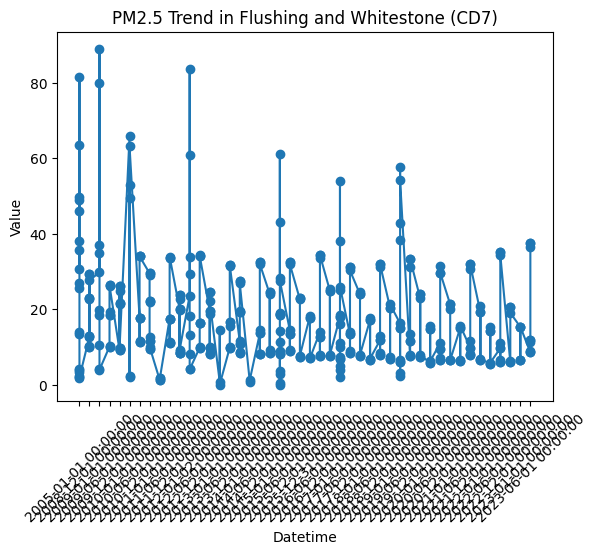

In [ ]:
# streamlit app for spotify + air quality

!pip install streamlit

import streamlit as st
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# connect to database
conn = sqlite3.connect('spotify_air_quality.db')

st.title("Spotify & Air Quality Dashboard")

# api
st.header("Spotify Tracks")

artist_input = st.text_input("Enter Artist Name (partial or full):")

if artist_input:
    query = f"""
    SELECT track_name, artist_name, popularity
    FROM spotify_tracks
    WHERE artist_name LIKE '%{artist_input}%'
    ORDER BY popularity DESC
    LIMIT 10
    """
    df_artist = pd.read_sql(query, conn)
    st.subheader(f"Top Tracks for '{artist_input}'")
    st.dataframe(df_artist)

    # plot popularity
    plt.barh(df_artist['track_name'], df_artist['popularity'], color='skyblue')
    plt.xlabel('Popularity')
    plt.ylabel('Track')
    plt.title(f'Top Tracks Popularity for {artist_input}')
    st.pyplot(plt)

# csv
st.header("Air Quality Trends")

cities = pd.read_sql("SELECT DISTINCT city FROM stations", conn)
city_selected = st.selectbox("Select a City:", cities['city'])

pollutants = pd.read_sql("SELECT DISTINCT pollutant FROM air_quality_observations", conn)
pollutant_selected = st.selectbox("Select a Pollutant:", pollutants['pollutant'])

if city_selected and pollutant_selected:
    query_aq = f"""
    SELECT a.datetime, a.value
    FROM air_quality_observations a
    JOIN stations s ON a.station_id = s.station_id
    WHERE s.city = '{city_selected}' AND a.pollutant = '{pollutant_selected}'
    ORDER BY a.datetime
    """
    df_aq = pd.read_sql(query_aq, conn)
    st.subheader(f"{pollutant_selected.upper()} Levels in {city_selected}")

    # Line plot
    plt.plot(df_aq['datetime'], df_aq['value'], marker='o')
    plt.xlabel('Datetime')
    plt.ylabel('Value')
    plt.title(f"{pollutant_selected.upper()} Trend in {city_selected}")
    plt.xticks(rotation=45)
    st.pyplot(plt)
